In [1]:
print("shree ram")

shree ram


In [2]:

import tensorflow as tf
print(tf.__version__)

2.10.0


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers,models

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

from pathlib import Path
import os.path
import random

import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')


from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [6]:
import urllib.request

url = 'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'
filename = 'helper_functions.py'

urllib.request.urlretrieve(url, filename)

('helper_functions.py', <http.client.HTTPMessage at 0x2470e346890>)

In [7]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [8]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [9]:

dataset = "C:/Minor Project-Research 1/bone fracture/mammals"
walk_through_dir(dataset);

There are 52 directories and 1 images in 'C:/Minor Project-Research 1/bone fracture/mammals'.
There are 0 directories and 0 images in 'C:/Minor Project-Research 1/bone fracture/mammals\.ipynb_checkpoints'.
There are 0 directories and 347 images in 'C:/Minor Project-Research 1/bone fracture/mammals\african_elephant'.
There are 0 directories and 333 images in 'C:/Minor Project-Research 1/bone fracture/mammals\alpaca'.
There are 0 directories and 343 images in 'C:/Minor Project-Research 1/bone fracture/mammals\american_bison'.
There are 0 directories and 299 images in 'C:/Minor Project-Research 1/bone fracture/mammals\anteater'.
There are 0 directories and 315 images in 'C:/Minor Project-Research 1/bone fracture/mammals\arctic_fox'.
There are 0 directories and 331 images in 'C:/Minor Project-Research 1/bone fracture/mammals\armadillo'.
There are 0 directories and 330 images in 'C:/Minor Project-Research 1/bone fracture/mammals\baboon'.
There are 0 directories and 310 images in 'C:/Minor P

In [10]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

C:\Users\AJEEB SAGAR\AppData\Local\Temp\ipykernel_23308\994582165.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')


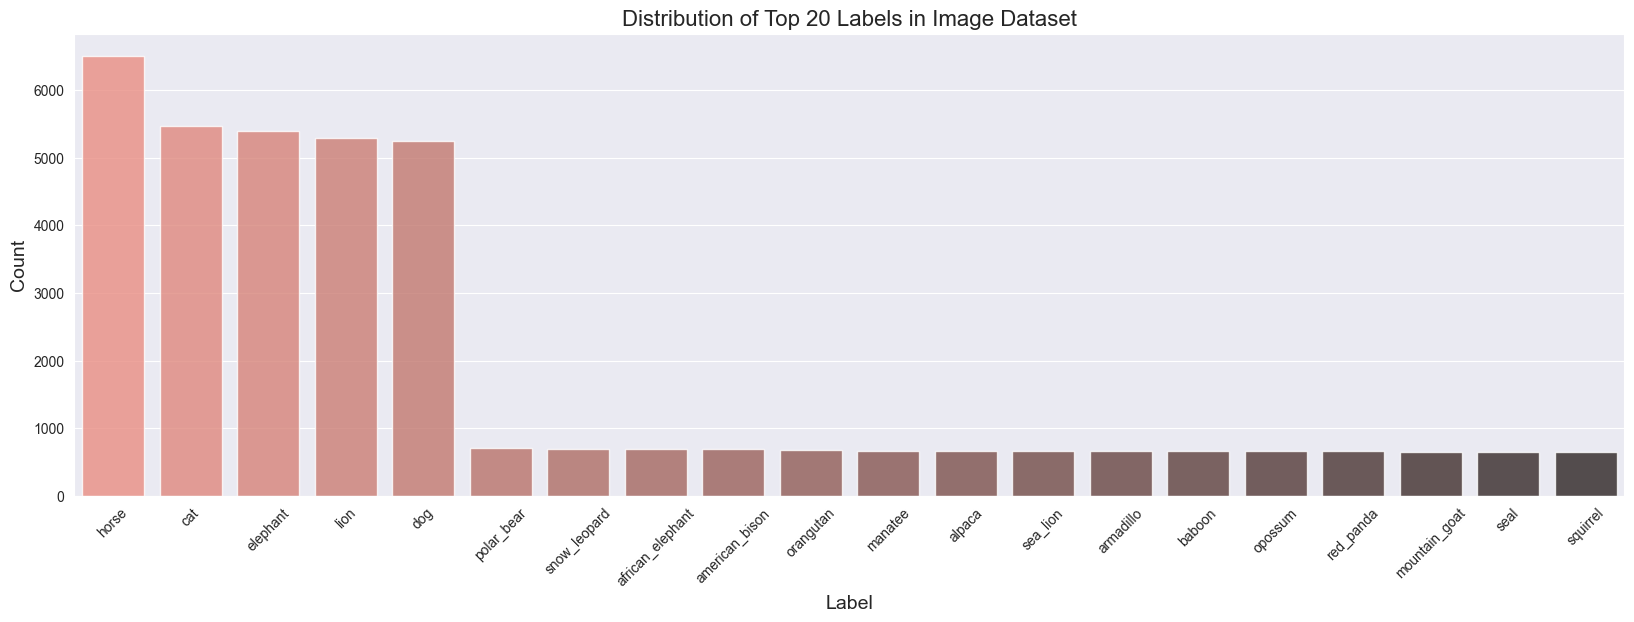

In [11]:
label_counts = image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

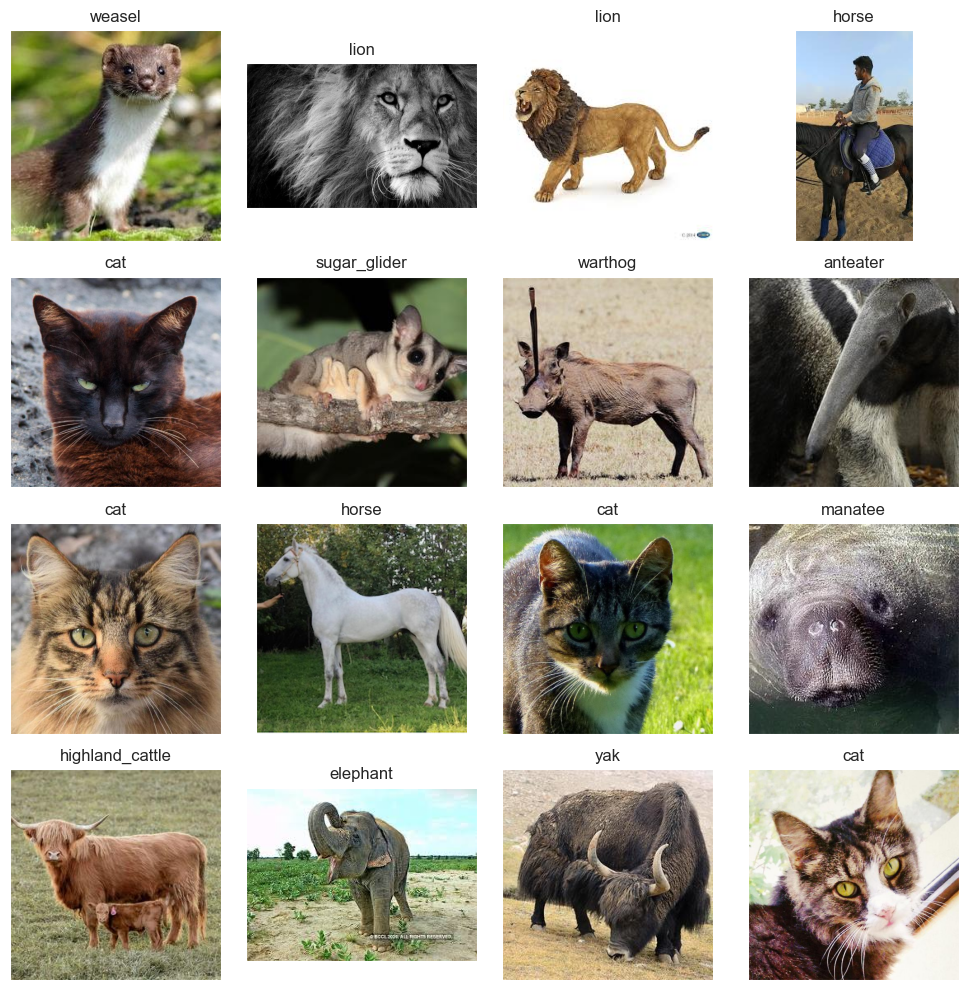

In [18]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [19]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

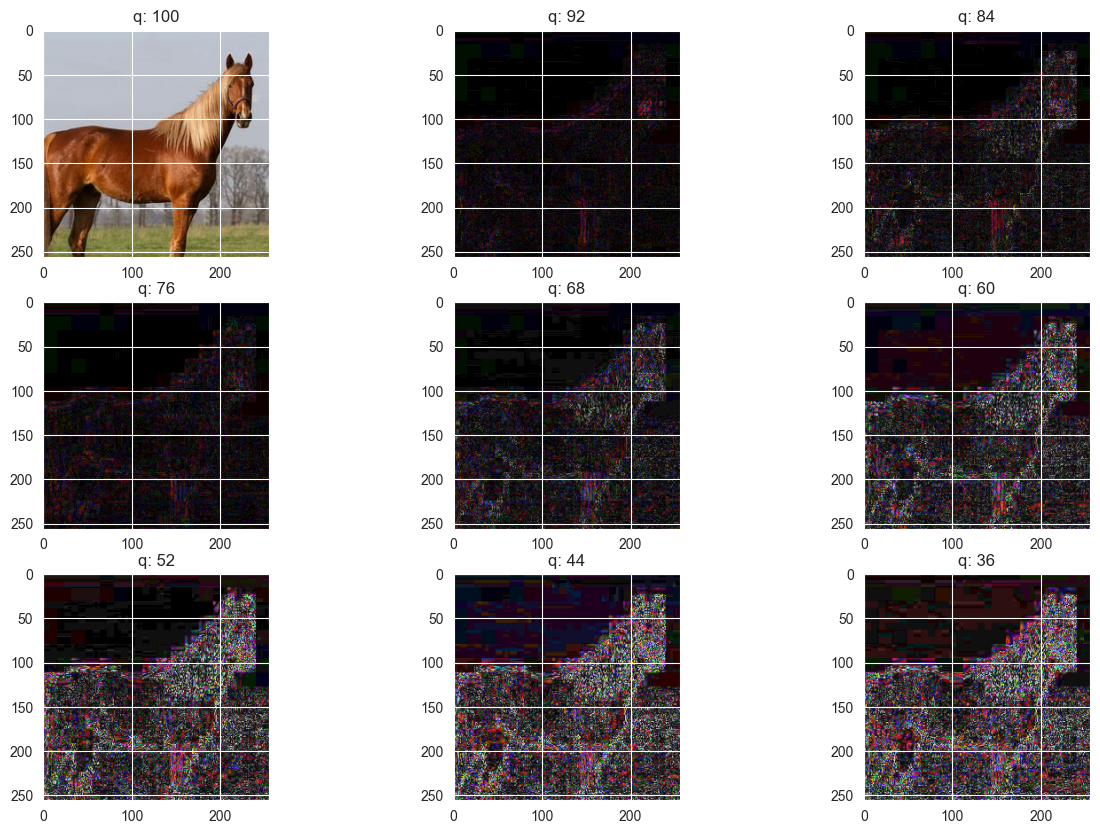

In [20]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Set the directory containing images
dir_path = 'C:\Minor Project-Research 1/bone fracture\horse'
image_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith(('.jpg', '.png'))]

# Choose a random image path
p = random.choice(image_files)
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0

# ELA parameters
init_val = 100
columns = 3
rows = 3

# Plotting
fig = plt.figure(figsize=(15, 10))
for i in range(1, columns * rows + 1):
    quality = init_val - (i - 1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()


In [21]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Split the data into training and testing datasets
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

# Define the image data generators
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2  # Use 20% of the training data for validation
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Parameters for image processing
TARGET_SIZE = (224, 224)  

# Generate training data
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'  # Specify the subset as training
)

# Generate validation data
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle validation data
    seed=42,
    subset='validation'  # Specify the subset as validation
)

# Generate testing data
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False  # Testing data should not be shuffled
)


Found 34732 validated image filenames belonging to 49 classes.
Found 8682 validated image filenames belonging to 49 classes.
Found 10854 validated image filenames belonging to 49 classes.


In [22]:
import tensorflow as tf
from tensorflow.keras import layers

# Data Augmentation Step
augment = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Load the pretrained MobileNetV2 model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [23]:

# Create checkpoint callback
checkpoint_path = "animals_classification_model_checkpoint.weights.h5" # Add .weights.h5 extension
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [24]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


In [25]:
!nvidia-smi

Sun Dec 15 21:49:22 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8              6W /   75W |    1835MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [26]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [27]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


# Change the output layer to have 49 units instead of 525
outputs = Dense(49, activation='softmax')(x) # Assuming you have 49 classes in your target

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=150,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "animals_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/animals_classification/20241215-214930
Epoch 1/150
1086/1086 [==============================] - 92s 79ms/step - loss: 2.7511 - accuracy: 0.3424 - val_loss: 1.5004 - val_accuracy: 0.6398 - lr: 1.0000e-04
Epoch 2/150
1086/1086 [==============================] - 77s 71ms/step - loss: 1.6234 - accuracy: 0.5704 - val_loss: 0.8514 - val_accuracy: 0.7817 - lr: 1.0000e-04
Epoch 3/150
1086/1086 [==============================] - 80s 73ms/step - loss: 1.2009 - accuracy: 0.6608 - val_loss: 0.5777 - val_accuracy: 0.8427 - lr: 1.0000e-04
Epoch 4/150
1086/1086 [==============================] - 81s 74ms/step - loss: 0.9694 - accuracy: 0.7189 - val_loss: 0.4648 - val_accuracy: 0.8724 - lr: 1.0000e-04
Epoch 5/150
1086/1086 [==============================] - 81s 75ms/step - loss: 0.8349 - accuracy: 0.7524 - val_loss: 0.3991 - val_accuracy: 0.8877 - lr: 1.0000e-04
Epoch 6/150
1086/1086 [==============================] - 83s 76ms/step - loss: 0.7254 - accura

In [28]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.14714
Test Accuracy: 96.09%


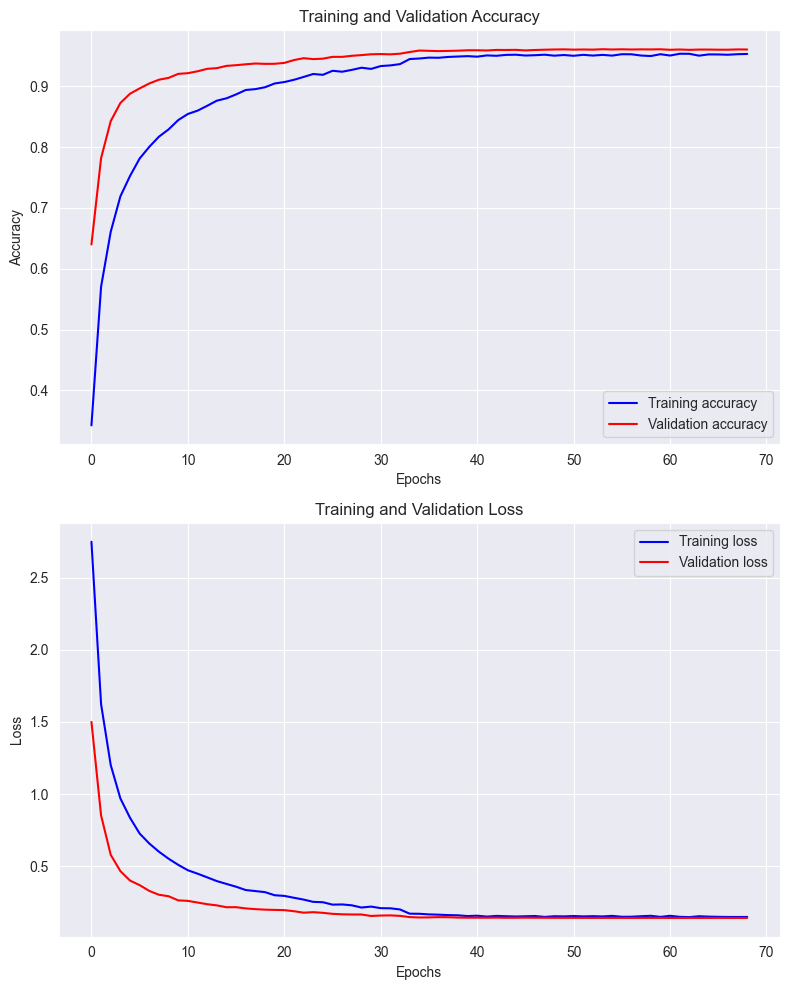

In [29]:
import matplotlib.pyplot as plt

# Check if `history` contains the expected keys
if 'accuracy' in history.history and 'val_accuracy' in history.history and 'loss' in history.history and 'val_loss' in history.history:
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))

    plt.figure(figsize=(8, 10))

    # Plot training and validation accuracy
    plt.subplot(2, 1, 1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)  # Add grid lines

    # Plot training and validation loss
    plt.subplot(2, 1, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # Add grid lines

    plt.tight_layout()
    plt.show()
else:
    print("Error: `history` object does not contain required keys.")


In [32]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

340/340 [==============================] - 18s 54ms/step
The first 10 predictions: ['giraffe', 'dog', 'lion', 'cat', 'vicuna', 'cat', 'walrus', 'tapir', 'elephant', 'horse']


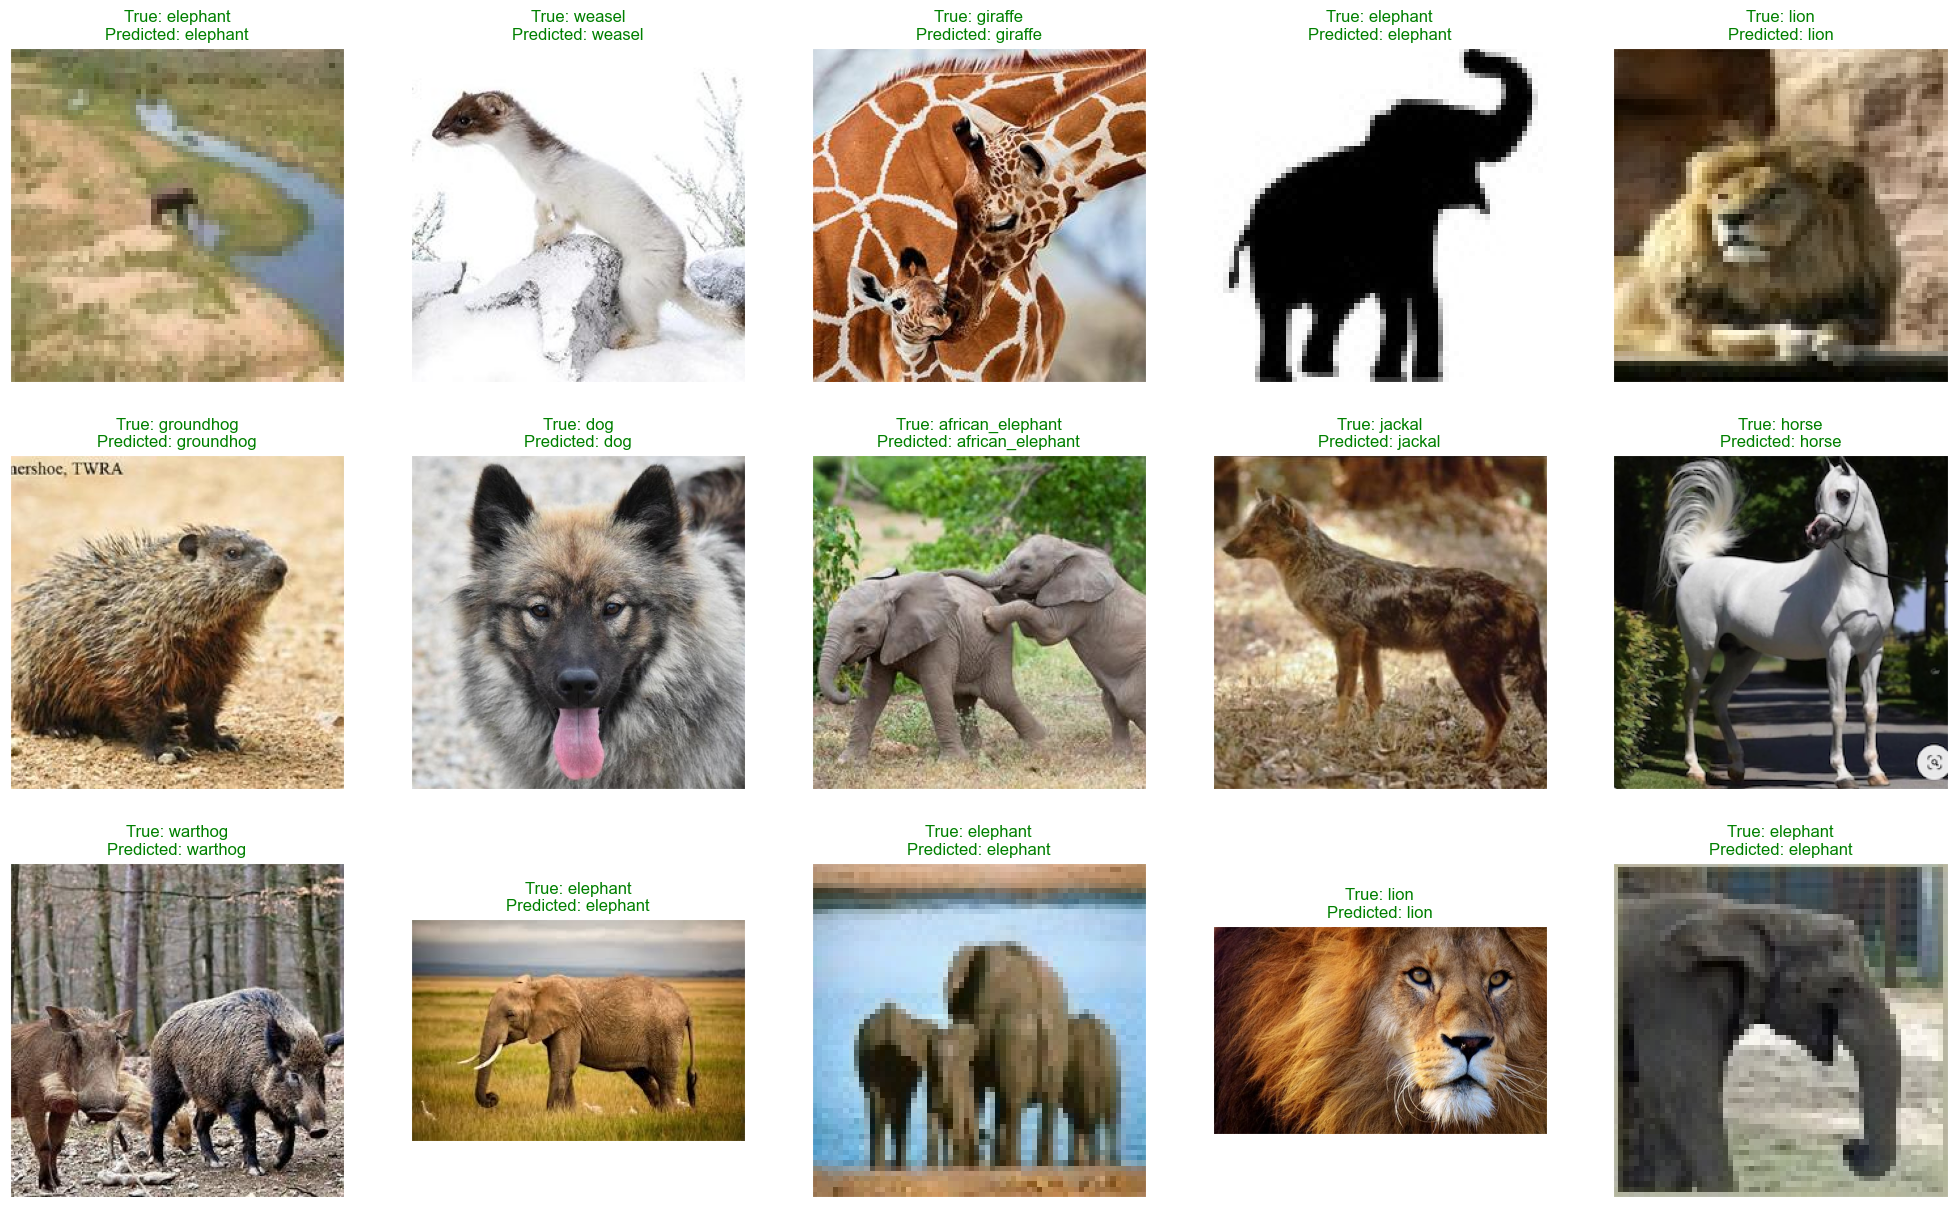

<Figure size 640x480 with 0 Axes>

In [33]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [34]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                  precision    recall  f1-score   support

african_elephant       0.84      0.88      0.86       133
          alpaca       0.96      0.92      0.94       142
  american_bison       0.98      0.96      0.97       127
        anteater       0.94      0.93      0.94       110
      arctic_fox       0.95      0.95      0.95       128
       armadillo       1.00      0.97      0.98       133
          baboon       0.96      0.98      0.97       131
          badger       0.97      0.94      0.95       124
      blue_whale       0.95      0.95      0.95        93
      brown_bear       0.97      0.98      0.97       138
           camel       0.94      0.97      0.96       102
             cat       1.00      1.00      1.00      1120
             dog       1.00      1.00      1.00      1085
         dolphin       0.98      0.97      0.97       129
        elephant       0.92      0.93      0.93      1027
         giraffe       0.99      0.99      0.99       143
       ground

In [35]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score       support
african_elephant   0.841727  0.879699  0.860294    133.000000
alpaca             0.962963  0.915493  0.938628    142.000000
american_bison     0.983871  0.960630  0.972112    127.000000
anteater           0.944444  0.927273  0.935780    110.000000
arctic_fox         0.953125  0.953125  0.953125    128.000000
armadillo          1.000000  0.969925  0.984733    133.000000
baboon             0.962687  0.984733  0.973585    131.000000
badger             0.974790  0.935484  0.954733    124.000000
blue_whale         0.946237  0.946237  0.946237     93.000000
brown_bear         0.971223  0.978261  0.974729    138.000000
camel              0.942857  0.970588  0.956522    102.000000
cat                0.998217  1.000000  0.999108   1120.000000
dog                0.997238  0.998157  0.997697   1085.000000
dolphin            0.976562  0.968992  0.972763    129.000000
elephant           0.920269  0.932814  0.926499   1027.000000
giraffe            0.986014  0.986014  0.986014    143.000000
groundhog          0.933884  0.991228  0.961702    114.000000
highland_cattle    0.983871  0.960630  0.972112    127.000000
horse              0.958621  0.949886  0.954233   1317.000000
jackal             0.969388  0.969388  0.969388     98.000000
kangaroo           0.963235  0.956204  0.959707    137.000000
koala              0.973214  1.000000  0.986425    109.000000
lion               0.946593  0.950971  0.948777   1081.000000
manatee            0.958042  0.992754  0.975089    138.000000
mongoose           0.970297  0.933333  0.951456    105.000000
mountain_goat      0.977612  0.977612  0.977612    134.000000
opossum            0.962963  0.992366  0.977444    131.000000
orangutan          1.000000  0.991453  0.995708    117.000000
otter              0.931034  0.987805  0.958580     82.000000
polar_bear         0.972414  0.986014  0.979167    143.000000
porcupine          0.976923  1.000000  0.988327    127.000000
red_panda          0.970149  0.984848  0.977444    132.000000
rhinoceros         0.923077  0.939130  0.931034    115.000000
sea_lion           0.845638  0.868966  0.857143    145.000000
seal               0.882883  0.790323  0.834043    124.000000
snow_leopard       0.992248  0.984615  0.988417    130.000000
squirrel           0.963504  0.949640  0.956522    139.000000
sugar_glider       0.988506  0.977273  0.982857     88.000000
tapir              0.968254  0.976000  0.972112    125.000000
vampire_bat        1.000000  0.944444  0.971429     90.000000
vicuna             0.941860  0.910112  0.925714     89.000000
walrus             0.913793  0.938053  0.925764    113.000000
warthog            1.000000  0.968750  0.984127     96.000000
water_buffalo      1.000000  0.845070  0.916031     71.000000
weasel             0.922414  0.938596  0.930435    114.000000
wildebeest         0.935484  0.974790  0.954733    119.000000
wombat             0.984252  0.939850  0.961538    133.000000
yak                0.898990  0.967391  0.931937     92.000000
zebra              1.000000  0.982456  0.991150    114.000000
accuracy           0.960936  0.960936  0.960936      0.960936
macro avg          0.958599  0.955661  0.956749  10854.000000
weighted avg       0.961229  0.960936  0.960905  10854.000000

In [39]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
  
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array) # Using grad_model here
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]


    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
  
    superimposed_img.save(cam_path)

 
    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

model.layers[-1].activation = None

C:\Users\AJEEB SAGAR\AppData\Local\Temp\ipykernel_23308\466219970.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


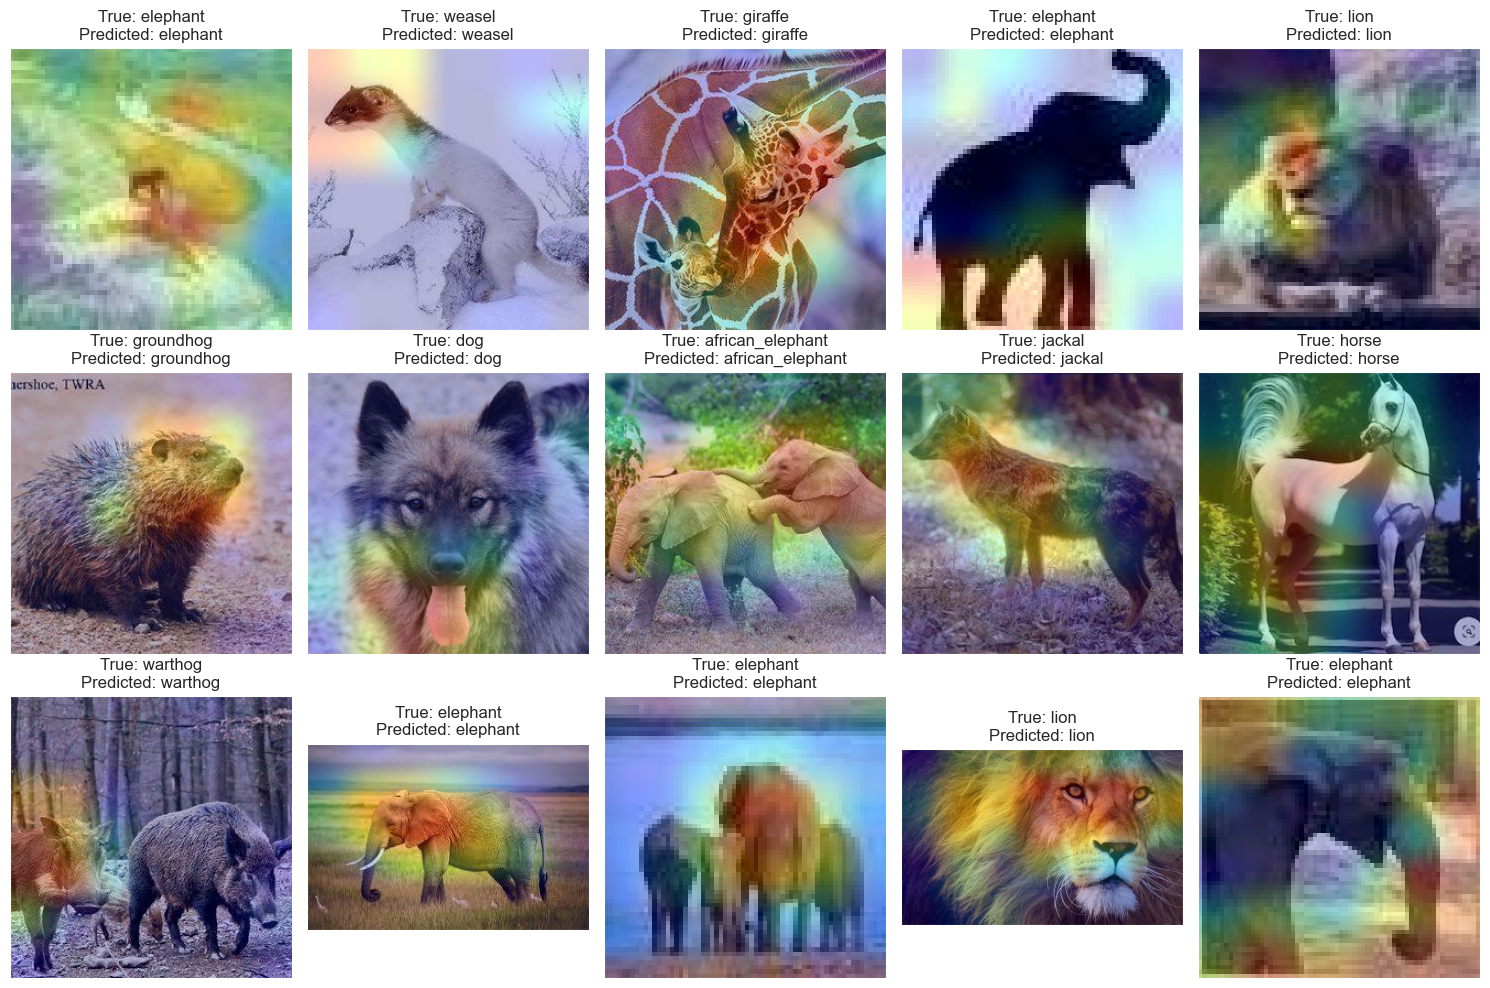

In [41]:

last_conv_layer_name = 'Conv_1' 
grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
)

# Ensure the rest of the code uses this corrected `last_conv_layer_name`
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()